In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import seaborn as sns
import jax
import ott
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from entot.models.utils import MixtureNormalSampler
from entot.models.gen_model import OTFlowMatching, MLP_FM_VAE2, Bridge_MLP
from entot.plotting.plots import plot_1D_balanced_new

2023-07-25 16:21:16.396201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


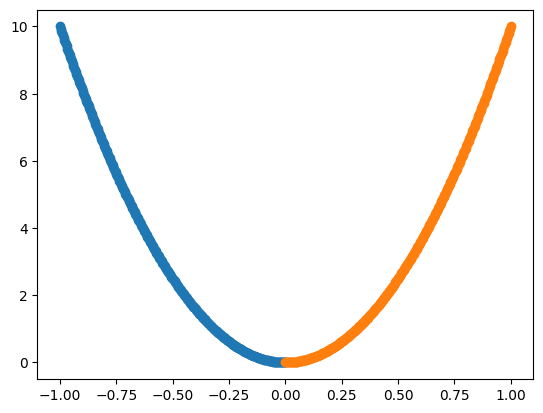

In [24]:
x0 = np.linspace(-1, 0, 300)
y0 = np.cos(x0) * 5 / + 0.1 * np.random.randn(len(x0))
data0 = np.concatenate((x0[:,None], y0[:,None]), axis=1)

x1 = np.linspace(0, 1, 300)
y1 = np.cos(x1) * 5 + 0.1 * np.random.randn(len(x1))
data1 = np.concatenate((x1[:,None], y1[:,None]), axis=1)

x0 = np.linspace(-1, 0, 300)
x1 = np.linspace(0, 1, 300)

y0 = 10*(x0**2)
y1 = 10*(x1**2)

source = np.concatenate((x0[:,None], y0[:,None]), axis=1)
target = np.concatenate((x1[:,None], y1[:,None]), axis=1)

plt.scatter(source[:,0], source[:,1])
plt.scatter(target[:,0], target[:,1])

In [36]:
neural_net = MLP_FM_VAE2(2, 128, 128, 128, n_frequencies=10)
bridge_net = Bridge_MLP(2, 64, 64)
ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()
solver_latent_to_data = ott.solvers.linear.sinkhorn.Sinkhorn()
graph_kwargs = {"k_neighbors": 512}
otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, epsilon=1e-1, input_dim=2, output_dim=2, iterations=10_000, k_noise_per_x=10, solver_latent_to_data=solver_latent_to_data, graph_kwargs=graph_kwargs)

In [37]:
otfm(source, target, 256, 256)

 19%|█▉        | 1913/10000 [03:30<14:48,  9.10it/s]


KeyboardInterrupt: 

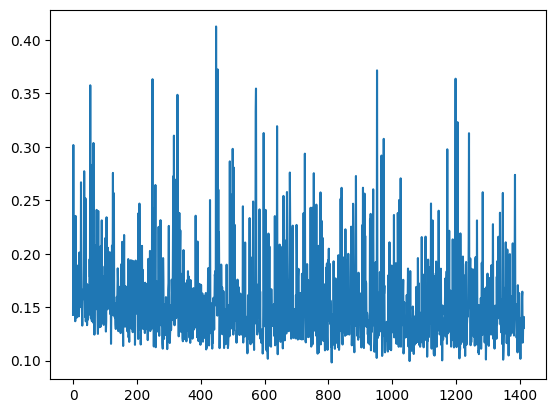

In [38]:
plt.plot(np.arange(len(otfm.metrics["loss"][500:])), otfm.metrics["loss"][500:])

In [39]:
res, _, _ = otfm.transport(source, seed=1, diffeqsolve_kwargs={"max_steps": 1_000_000})
pushed_source = res[0,...]

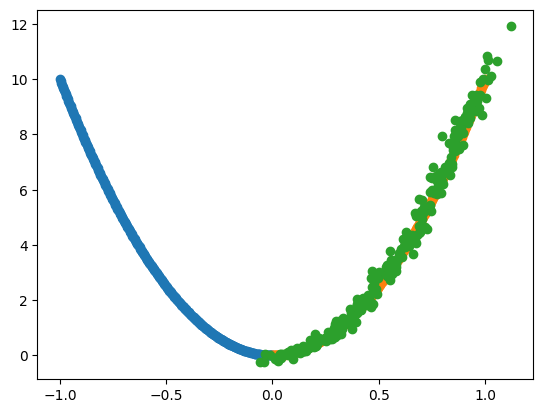

In [40]:
plt.scatter(source[:,0], source[:,1])
plt.scatter(target[:,0], target[:,1])
plt.scatter(pushed_source[:,0], pushed_source[:,1])

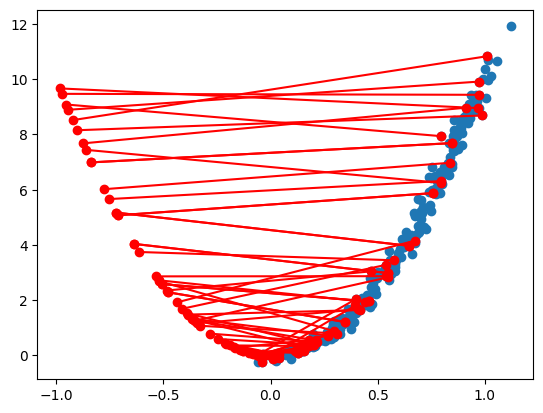

In [42]:
plt.scatter(pushed_source[:,0], pushed_source[:,1])
indices = jax.random.randint(jax.random.PRNGKey(1), (60,), 0, len(data0))

plt.plot([source[indices, 0], pushed_source[indices, 0]],[source[indices, 1],pushed_source[indices, 1]] ,'ro-')
plt.show()


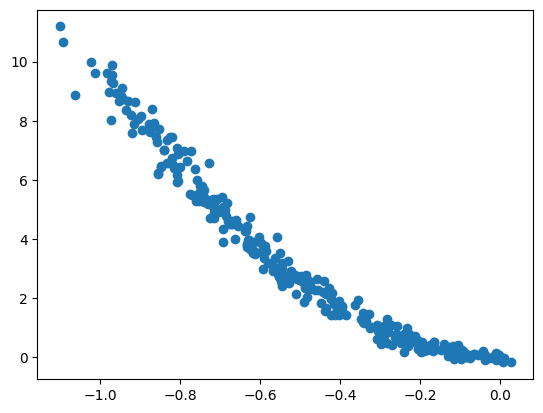

In [20]:
plt.scatter(pushed_source[0,:,0], pushed_source[0,:,1])

In [75]:
from typing import Tuple 

def get_nearest_neighbors(
        X: jnp.ndarray, Y: jnp.ndarray, len_x: int, k: int = 301  # type: ignore[name-defined]
    ) -> Tuple[jnp.ndarray, jnp.ndarray]:  # type: ignore[name-defined]
        concat = jnp.concatenate((X, Y), axis=0)
        pairwise_euclidean_distances = ott.geometry.pointcloud.PointCloud(concat, concat).cost_matrix
        distances, indices = jax.lax.approx_min_k(
            pairwise_euclidean_distances, k=k, recall_target=0.95, aggregate_to_topk=True
        )
        return distances, indices

distances, indices = get_nearest_neighbors(source, target, len(source), 301)
            

In [76]:
X = source
Y = target

a = jnp.full((len(X) + len(Y), len(X) + len(Y)), 0.0)
adj_matrix = a.at[
    jnp.repeat(jnp.arange(len(X) + len(Y)), repeats=301).flatten(), indices.flatten()
].set(distances.flatten())


<Axes: >

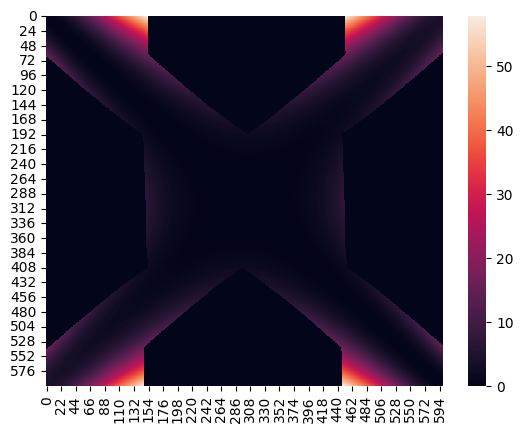

In [77]:
sns.heatmap(adj_matrix)

In [67]:
geom = ott.geometry.geometry.Geometry(cost_matrix=adj_matrix[:len(source), len(source):])
out = ott.solvers.linear.sinkhorn.Sinkhorn()(
    ott.problems.linear.linear_problem.LinearProblem(geom)
)


In [68]:
len(source)

300

In [69]:
sinkhorn_output=out

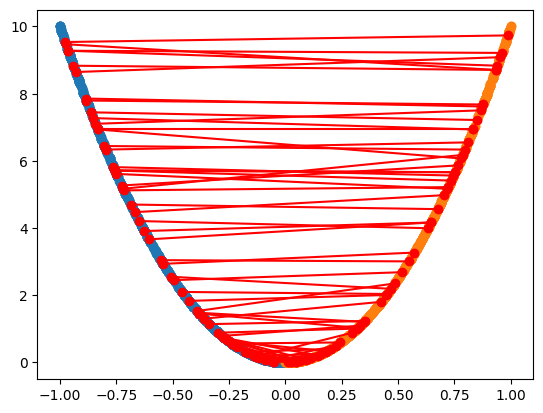

In [71]:
pi_star_inds = jax.random.categorical(
        jax.random.PRNGKey(0), logits=jnp.log(sinkhorn_output.matrix.flatten()), shape=(1000,)
    )
inds_source = pi_star_inds // len(target)
inds_target = pi_star_inds % len(target)
source_gt = source[inds_source]
target_gt = target[inds_target]

plt.scatter(source_gt[:,0], source_gt[:,1])
plt.scatter(target_gt[:,0], target_gt[:,1])
indices = jax.random.randint(jax.random.PRNGKey(0), (60,), 0, len(source_gt))
plt.plot([source_gt[indices, 0],target_gt[indices, 0]],[source_gt[indices, 1],target_gt[indices, 1]] ,'ro-')
plt.show()

In [72]:
import networkx as nx
from networkx.algorithms import tree


In [81]:
type(adj_matrix)

jaxlib.xla_extension.ArrayImpl

In [82]:
G = nx.from_numpy_array(np.asarray(adj_matrix))

In [83]:
mst = tree.minimum_spanning_edges(G, algorithm="kruskal", data=False)

In [85]:
edgelist = list(mst)

In [88]:

ind = np.asarray(edgelist)

In [150]:
adj_matrix = np.asarray(adj_matrix)
sparse_adj_matrix= np.full((600, 600), 0.0)
for i in range(len(ind)):
    #print(adj_matrix[ind[i,0], ind[i,1]])
    sparse_adj_matrix[ind[i,0], ind[i,1]] = adj_matrix[ind[i,0], ind[i,1]]

In [152]:
G2 = nx.from_numpy_array(np.asarray(sparse_adj_matrix))

In [153]:
spl = nx.shortest_path_length(G2)

In [154]:
sp = list(spl)

In [187]:
cm = np.zeros((300, 300))
for i in range(300):
    for j in range(300):
        cm[i,j] = sp[i][1][j+300]*10

<Axes: >

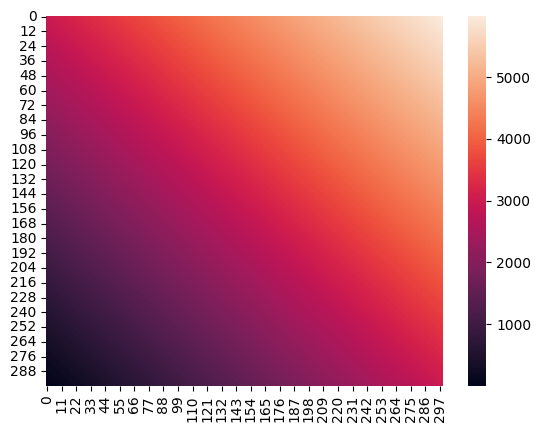

In [188]:
sns.heatmap(cm)

In [178]:
sp[2][0]

2

In [189]:
geom = ott.geometry.geometry.Geometry(cost_matrix=cm, epsilon=1e-3)
out = ott.solvers.linear.sinkhorn.Sinkhorn()(
    ott.problems.linear.linear_problem.LinearProblem(geom)

)

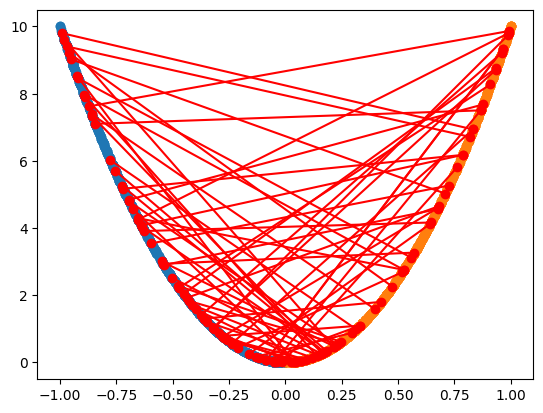

In [190]:
sinkhorn_output = out

pi_star_inds = jax.random.categorical(
        jax.random.PRNGKey(0), logits=jnp.log(sinkhorn_output.matrix.flatten()), shape=(1000,)
    )
inds_source = pi_star_inds // len(target)
inds_target = pi_star_inds % len(target)
source_gt = source[inds_source]
target_gt = target[inds_target]

plt.scatter(source_gt[:,0], source_gt[:,1])
plt.scatter(target_gt[:,0], target_gt[:,1])
indices = jax.random.randint(jax.random.PRNGKey(0), (60,), 0, len(source_gt))
plt.plot([source_gt[indices, 0],target_gt[indices, 0]],[source_gt[indices, 1],target_gt[indices, 1]] ,'ro-')
plt.show()

In [197]:
cm2 = ott.geometry.graph.Graph.from_graph(sparse_adj_matrix, t=0.1).cost_matrix

<Axes: >

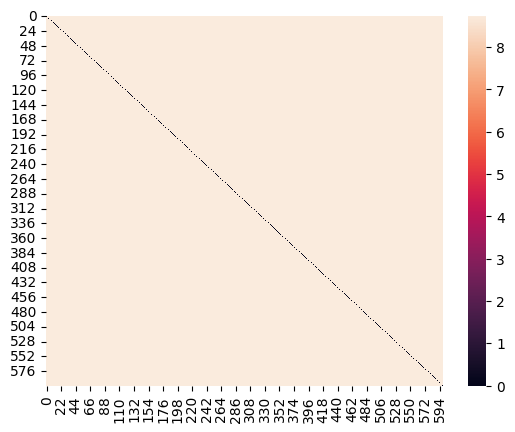

In [198]:
sns.heatmap(cm2)

In [199]:
cm2

Array([[ 4.7684857e-06,  8.7336550e+00,  8.7336550e+00, ...,
         8.7336550e+00,  8.7336550e+00,  8.7336550e+00],
       [ 8.7336550e+00,  4.7684857e-06,  8.7336550e+00, ...,
         8.7336550e+00,  8.7336550e+00,  8.7336550e+00],
       [ 8.7336550e+00,  8.7336550e+00,  4.7684857e-06, ...,
         8.7336550e+00,  8.7336550e+00,  8.7336550e+00],
       ...,
       [ 8.7336550e+00,  8.7336550e+00,  8.7336550e+00, ...,
         4.7684857e-06,  8.7336550e+00,  8.7336550e+00],
       [ 8.7336550e+00,  8.7336550e+00,  8.7336550e+00, ...,
         8.7336550e+00,  4.7684857e-06,  8.7336550e+00],
       [ 8.7336550e+00,  8.7336550e+00,  8.7336550e+00, ...,
         8.7336550e+00,  8.7336550e+00, -0.0000000e+00]], dtype=float32)

In [205]:
xgeom = ott.geometry.geometry.Geometry(cost_matrix=cm2, epsilon=1e-1)
out = ott.solvers.linear.sinkhorn.Sinkhorn(max_iterations=1e7)(
    ott.problems.linear.linear_problem.LinearProblem(geom)

)

In [204]:
out.converged

Array(False, dtype=bool)

In [ ]:
sinkhorn_output = out

pi_star_inds = jax.random.categorical(
        jax.random.PRNGKey(0), logits=jnp.log(sinkhorn_output.matrix.flatten()), shape=(1000,)
    )
inds_source = pi_star_inds // len(target)
inds_target = pi_star_inds % len(target)
source_gt = source[inds_source]
target_gt = target[inds_target]

plt.scatter(source_gt[:,0], source_gt[:,1])
plt.scatter(target_gt[:,0], target_gt[:,1])
indices = jax.random.randint(jax.random.PRNGKey(0), (60,), 0, len(source_gt))
plt.plot([source_gt[indices, 0],target_gt[indices, 0]],[source_gt[indices, 1],target_gt[indices, 1]] ,'ro-')
plt.show()